In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import mpl
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import shap
import warnings

warnings.filterwarnings("ignore")
#pd.set_option('max_column', 40)
#plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 支持中文显示

# notebook环境下，加载用于可视化的JS代码
shap.initjs()

In [112]:
# 读取数据，目标变量y是发病率
data = pd.read_csv('D://毕业设计//result//机器学习//16week机器学习69countries.csv')
#选择特征
#cols = ['HDI', 'SDI', 'HIV/AIDS Infection', 'ILGA_Index', 'health_GDP rate', 'population_density', 'Substance_use_disorders', 'Substance_use_Rate','Alcohol_consumption','Vaccines agreement','2019Arrivals','movement_change','stay_ratio']

In [146]:
# XGBoost建模数据准备=====================================================
data_result = data.iloc[:,0]
data_input = data.iloc[:, 3:10]
print(data_result)

0       0
1       1
2       1
3       1
4       1
       ..
1099    5
1100    5
1101    5
1102    5
1103    5
Name: morbidity_Rank, Length: 1104, dtype: int64


In [147]:
# 准备xgb训练集和测试集
train_x, test_x, train_y, test_y = train_test_split(data_input, data_result, test_size=0.02, random_state=1)

In [148]:
# 查看训练集和测试集的特征值形状
print(train_x.shape, test_x.shape)
print(type(data.iloc[1,1]))
# 查看训练集各类型选择的抽样数量
train_y.value_counts()

(1081, 7) (23, 7)
<class 'numpy.int64'>


5    261
3    225
1    205
2    196
4    191
0      3
Name: morbidity_Rank, dtype: int64

In [149]:
# xgb：多分类================================================================
dtrain = xgb.DMatrix(train_x,train_y)
dtest = xgb.DMatrix(test_x)
# 参数
# objective：多分类'multi:softmax'返回预测的类别，
params = {'booster': 'gbtree',
          'objective': 'multi:softmax', #多分类'multi:softmax'返回预测的类别(不是概率)，'multi:softprob'返回概率
          'num_class': 6,
          'eval_metric': 'merror', #二分类用’auc‘，多分类用'mlogloss'或'merror'
          'max_depth': 7,
          'lambda': 15,
          'subsample': 0.75,
          'colsample_bytree': 0.75,
          'min_child_weight': 1,
          'eta': 0.025,
          'seed': 0,
          'nthread': 8,
         #'silent': 0,
          'gamma': 0.15,
          'learning_rate': 0.01}
plst = params.items()
print("plst：\n", plst)
plst = list(params.items())
print("list(plst)：\n", plst)
#watchlist = [(dtrain, 'train')]


plst：
 dict_items([('booster', 'gbtree'), ('objective', 'multi:softmax'), ('num_class', 6), ('eval_metric', 'merror'), ('max_depth', 7), ('lambda', 15), ('subsample', 0.75), ('colsample_bytree', 0.75), ('min_child_weight', 1), ('eta', 0.025), ('seed', 0), ('nthread', 8), ('gamma', 0.15), ('learning_rate', 0.01)])
list(plst)：
 [('booster', 'gbtree'), ('objective', 'multi:softmax'), ('num_class', 6), ('eval_metric', 'merror'), ('max_depth', 7), ('lambda', 15), ('subsample', 0.75), ('colsample_bytree', 0.75), ('min_child_weight', 1), ('eta', 0.025), ('seed', 0), ('nthread', 8), ('gamma', 0.15), ('learning_rate', 0.01)]


In [150]:
# 建模与预测:NUM_BOOST_round迭代次数和数的个数一致
model = xgb.train(plst, dtrain, num_boost_round=50)
ypred = model.predict(dtest)

# test_y为data抽样的索引，重置后便于与模型预测结果比较===============================
test_y = test_y.reset_index(drop=True)
# 手动计算准确率
cnt1 = 0
cnt2 = 0
for i in range(len(test_y)):
    if ypred[i] == test_y[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))

Accuracy: 91.30 % 


In [151]:
# 混淆矩阵，对角线为正确，其他为误分类
metrics.confusion_matrix(test_y,ypred)

array([[ 5,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0],
       [ 0,  1,  2,  0,  0],
       [ 0,  0,  1,  1,  0],
       [ 0,  0,  0,  0, 10]], dtype=int64)

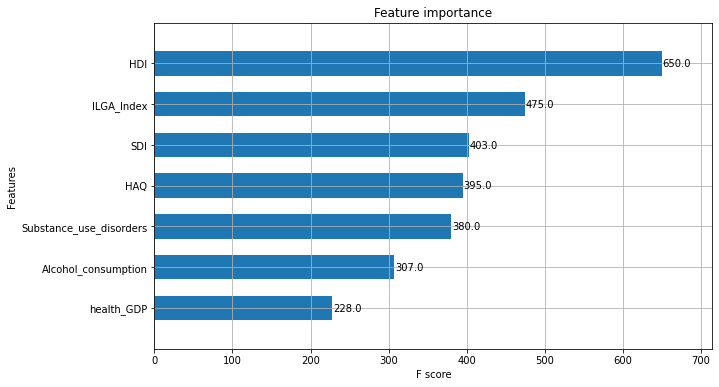

In [152]:
# 模型结果解释==================================================================
# xgb.plot_importance(model)

fig,ax = plt.subplots(figsize=(10,6))# 调节图像尺寸
xgb.plot_importance(model,
                height=0.6,# 调节线宽
                ax = ax)#调节显示数目
# plt.savefig("D://毕业设计//result//机器学习//PDP//发病率特征重要性.png",dpi=1000,bbox_inches = 'tight')
plt.show()


In [153]:
#SHAP解释模型=================================================================
# 解决xgb中utf-8不能编码问题

# 对model的编码，删除binf
model_modify = model.save_raw()[4:]
def myfun(self=None):
    return model_modify
model.save_raw = myfun


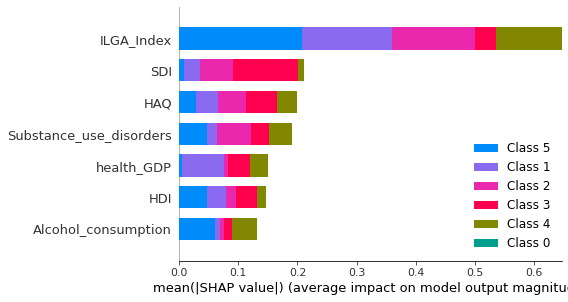

In [154]:
# SHAP计算
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)

# 特征统计值
shap.summary_plot(shap_values, train_x,show=False)
# plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率数SHAP.png",dpi=1000)

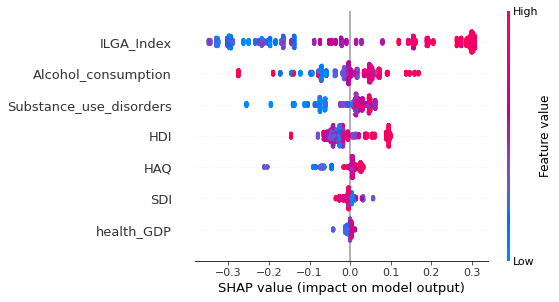

In [155]:
# SHAP值解释
# shap.summary_plot(shap_values[0], train_x, max_display=15)
# 图4
# shap.summary_plot(shap_values[1], train_x, max_display=15,show=False)
# plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率等级1.png",dpi=1000)
# shap.summary_plot(shap_values[2], train_x, max_display=15,show=False)
# plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率等级2.png",dpi=1000)
# shap.summary_plot(shap_values[3], train_x, max_display=15,show=False)
# plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率等级3.png",dpi=1000)
# shap.summary_plot(shap_values[4], train_x, max_display=15,show=False)
# plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率等级4.png",dpi=1000)
shap.summary_plot(shap_values[5], train_x, max_display=15,show=False)
# plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率等级5.png",dpi=1000)

In [156]:
# 训练集第1个样本对于输出结果为1的SHAP解释
# shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], train_x.iloc[1,:])
shap.force_plot(explainer.expected_value[5], shap_values[1][1,:], train_x.iloc[950,:])

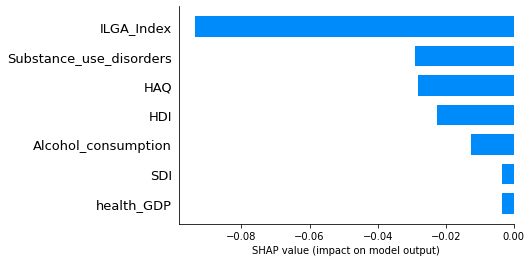

In [157]:
# 统计图解释
cols = train_x.columns.tolist()
shap.bar_plot(shap_values[1][1,:],feature_names=cols)


In [158]:
# 输出第1个样本的特征值和shap值
sample_explainer = pd.DataFrame()
sample_explainer['feature'] = cols
sample_explainer['feature_value'] = train_x[cols].iloc[5].values
sample_explainer['shap_value'] = shap_values[5][1]
sample_explainer


feature  feature_value  shap_value
0                      HDI       0.887000    0.094430
1                      SDI       0.794000   -0.005202
2                      HAQ      87.000000    0.025164
3               health_GDP       4.000000    0.003106
4               ILGA_Index       0.464789    0.299699
5  Substance_use_disorders       3.400000    0.046364
6      Alcohol_consumption      12.330000    0.052868

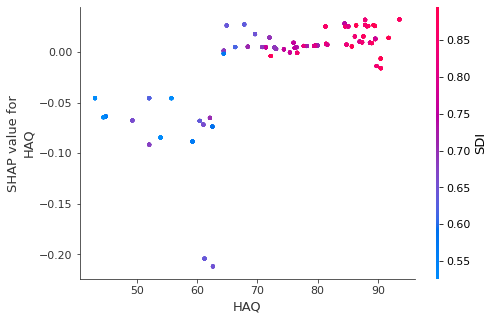

In [161]:
# 单个特征与模型预测结果的关系
# shap.dependence_plot('ILGA_Index', shap_values[3], train_x[cols], display_features=train_x[cols],interaction_index=None)
# shap.dependence_plot('SDI', shap_values[3], train_x[cols], display_features=train_x[cols],interaction_index=None)
# shap.dependence_plot('HAQ', shap_values[3], train_x[cols], display_features=train_x[cols],interaction_index=None)
# shap.dependence_plot('HDI', shap_values[3], train_x[cols], display_features=train_x[cols],interaction_index=None)

# shap.dependence_plot('ILGA_Index', shap_values[5], train_x[cols], display_features=train_x[cols],interaction_index='HAQ',show=False)
# plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率因子交互1.png",dpi=1000,bbox_inches = 'tight')
# shap.dependence_plot('ILGA_Index', shap_values[5], train_x[cols], display_features=train_x[cols],interaction_index='SDI',show=False)
# plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率因子交互2.png",dpi=1000,bbox_inches = 'tight')
shap.dependence_plot('HAQ', shap_values[5], train_x[cols], display_features=train_x[cols],interaction_index='SDI',show=False)
plt.savefig("D://毕业设计//result//机器学习//SHAP//发病率因子交互3.png",dpi=1000,bbox_inches = 'tight')
# shap.dependence_plot('HAQ', shap_values[3], train_x[cols], display_features=train_x[cols],interaction_index='HDI')
# 前100个样本的shap累计解释，可选择坐标内容
# shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], train_x.iloc[:1000,:])


In [17]:
# # 训练xgboost回归模型
# model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
# model.fit(data[cols], data['morbidity'].values)

In [18]:
# # 获取feature importance
# plt.figure(figsize=(15, 5))
# plt.bar(range(len(cols)), model.feature_importances_)
# plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
# plt.title('Feature importance', fontsize=14)
# plt.show()

In [ ]:
# import shap
# # model是在第1节中训练的模型
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(data[cols])
# print(shap_values.shape)


In [ ]:
# y_base = explainer.expected_value
# print(y_base)

# data['pred'] = model.predict(data[cols])
# print(data['pred'].mean())


In [ ]:
# # 比如我们挑选数据集中的第30位
# j = 30
# player_explainer = pd.DataFrame()
# player_explainer['feature'] = cols
# #某行
# player_explainer['feature_value'] = data[cols].iloc[j].values
# player_explainer['shap_value'] = shap_values[j]
# player_explainer


In [ ]:
# print('y_base + sum_of_shap_values: %.2f'%(y_base + player_explainer['shap_value'].sum()))
# print('y_pred: %.2f'%(data['pred'].iloc[j]))


In [ ]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[j], data[cols].iloc[j])


In [ ]:
# shap.summary_plot(shap_values, data[cols])


In [ ]:
# shap.summary_plot(shap_values, data[cols], plot_type="bar")
